In [1]:
import os
import pandas as pd
from tqdm import tqdm
import plotly.express as px
from scipy.optimize import least_squares
from lmfit.models import LorentzianModel, GaussianModel, LinearModel
from matplotlib import pyplot as plt
import numpy as np
import lmfit
from lmfit import Model
from datetime import datetime, timedelta, date
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import joblib
import mpl_scatter_density

In [2]:
def get_df_from_dir(directory = "C:/Users/syversk/Desktop/cr1"):
    files = os.listdir(directory)
    df_list = []
    for file in tqdm(files):
        df_list.append(pd.read_csv(directory + "/" + file))
    return pd.concat(df_list)

df_cr_p = pd.concat([get_df_from_dir("C:/Users/syversk/Desktop/mss_v3.0/cr1_north_pasific"), get_df_from_dir("C:/Users/syversk/Desktop/mss_v3.0/cr2_south_pasific")])
df_cr = pd.concat([get_df_from_dir("C:/Users/syversk/Desktop/mss_v3.0/cr1"), get_df_from_dir("C:/Users/syversk/Desktop/mss_v3.0/cr2")])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1267/1267 [00:13<00:00, 93.56it/s]


In [3]:
df_cr, df_cr_p

(          mss        lat         lon           time  era_wind  oscar_current  \
 0     0.00760 -10.011209  119.156151  226351.683472    6.3618         0.2951   
 1     0.00767 -10.041997  119.200737  226351.683750    6.2891         0.2725   
 2     0.00763 -10.072998  119.245300  226351.684028    6.2166         0.2500   
 3     0.00757 -10.104008  119.289871  226351.684306    6.1574         0.2274   
 4     0.00703 -10.135011  119.334442  226351.684583    6.1007         0.2065   
 ...       ...        ...         ...            ...       ...            ...   
 4273  0.01368  10.143293  138.266693  257032.681042    4.5002         0.2455   
 4274  0.01498  10.111274  138.311096  257032.681319    4.5032         0.2375   
 4275  0.01283  10.079271  138.355499  257032.681597    4.5235         0.2305   
 4276  0.01187  10.039236  138.410980  257032.681944    4.5648         0.2244   
 4277  0.01289  10.015222  138.444275  257032.682153    4.5902         0.2209   
 
          delta  
 0     6

In [4]:
df_cr.corr(), df_cr_p.corr()

(                    mss       lat       lon      time  era_wind  \
 mss            1.000000  0.091989  0.063997 -0.052643  0.746921   
 lat            0.091989  1.000000  0.930191  0.031063  0.001527   
 lon            0.063997  0.930191  1.000000  0.033653 -0.012836   
 time          -0.052643  0.031063  0.033653  1.000000 -0.035701   
 era_wind       0.746921  0.001527 -0.012836 -0.035701  1.000000   
 oscar_current  0.061856  0.097131  0.025408 -0.073629  0.052354   
 delta          0.745927 -0.009323 -0.023012 -0.034202  0.998008   
 
                oscar_current     delta  
 mss                 0.061856  0.745927  
 lat                 0.097131 -0.009323  
 lon                 0.025408 -0.023012  
 time               -0.073629 -0.034202  
 era_wind            0.052354  0.998008  
 oscar_current       1.000000  0.033058  
 delta               0.033058  1.000000  ,
                     mss       lat       lon      time  era_wind  \
 mss            1.000000 -0.066767  0.080346 -0.0

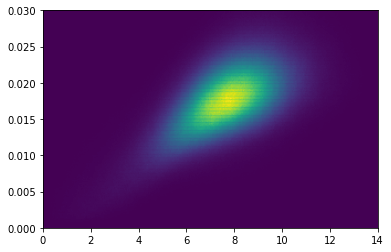

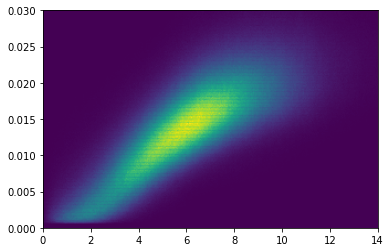

In [8]:
def plot_df_fast(df, filename):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    ax.scatter_density(df.era_wind, df.mss)
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 0.03)
    fig.savefig("v3.0_results/" + filename)
plot_df_fast(df_cr_p, "wind_mss_cr_pasific")
plot_df_fast(df_cr, "wind_mss_cr_towards")

In [13]:
def get_heatmap(df, arg = "era_wind"):
    fig = px.density_heatmap(df, y="mss", x=arg, color_continuous_scale=px.colors.sequential.Blackbody)
    fig.update_layout(
        xaxis_title= r"$\text{" + arg + "}$",
        yaxis_title= r"$\text{MSS}$",
        legend_title="Legend Title",
        font=dict(
            size=16,
        )
    )
    fig.show()
df_mini = df_cr_p[df_cr_p['era_wind'] < 12]
df_mini = df_mini[df_mini['mss'] < 0.04].iloc[0:100000]
get_heatmap(df_mini,"era_wind")

In [14]:
class KatzbergModel(Model):
    def __init__(self, *args, **kwargs):
        def katzberg(x, c_1, c_2, c_3, c_4, c_5):
            output = []
            for i in range(len(x)):
                if x[i] <= 3.49:
                    output.append(c_1*(c_2*x[i] + c_3))
                else:
                    output.append(c_1*(c_4*np.log(x[i]) + c_5))
            return np.array(output)
                    
        super(KatzbergModel, self).__init__(katzberg, *args, **kwargs)

    def guess(self, data, **kwargs):
        params = self.make_params()
        def pset(param, value):
            params["%s%s" % (self.prefix, param)].set(value=value)
        pset("c_1", 0.0035)
        pset("c_2", 1)
        pset("c_3", 0.62)
        pset("c_4", 6)
        pset("c_5", -3.39)
        return lmfit.models.update_param_vals(params, self.prefix, **kwargs)

In [15]:
def fit_emprical_model(df, file_name):
    X_train, X_test, Y_train, Y_test = train_test_split (df.era_wind.to_numpy().reshape(-1, 1), df.mss, test_size = 0.001, random_state=42)
    
    # Fit Katzberg Model
    model = KatzbergModel()
    y = df['mss'].to_numpy()
    x = df['era_wind'].to_numpy()
    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    res_str = result.fit_report()

    text_file = open("v3.0_results/" + file_name + ".txt", "w")
    n = text_file.write(res_str)
    text_file.close()
 
    #Fit Gradit Boosting DT
    model = GradientBoostingRegressor(random_state=18, n_estimators=50)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    print (mean_squared_error(Y_test, predictions))
    file = "v3.0_results/" + file_name + ".pkl"
    joblib.dump(model, file)

In [16]:
fit_emprical_model(df_cr_p, "model_cr_pasific")
fit_emprical_model(df_cr, "model_cr_towards")

1.3333591708900479e-05
1.662048183822611e-05


In [ ]:
# Below here old code to check for which model is best

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=2, random_state=19, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
rescaledX = scaler.fit_transform(X_train)
joblib.dump(scaler, 'std_scaler.bin', compress=True)

param_grid = dict(n_estimators=np.array([50,100,200,300,400]))
model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=2, random_state=21, shuffle = True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
model = joblib.load("model.pkl")
scaler=joblib.load('std_scaler.bin')
# transform the validation dataset
print(X_test.shape)
rescaled_X_test = scaler.transform(X_test)
predictions = model.predict(rescaled_X_test)
print (mean_squared_error(Y_test, predictions))